Model roughly referred from: [TowardsDataScience | One Shot Learning with Siamese Networks using Keras](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d)

In [0]:
import gzip
import shutil
import tarfile

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
image_zip = '/content/drive/My Drive/GoogleCollab/data/Signatures/'
tar = tarfile.open(image_zip+'signatures.tar.gz')
tar.extractall()
tar.close()

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2
from numpy import random as rng
from sklearn.utils import shuffle
import pickle
import time

from tensorflow.keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
image_orig_dir = '/content/signatures/full_org'
image_forge_dir = '/content/signatures/full_forg'

In [0]:
def calcResizedShape(shape,maxW,maxH):
  '''
  shape of cv2 image is height x width
  But cv2.resize expects width x height -_-
  '''
  if shape[0] > shape[1]:
    return (int(maxH / shape[0] * shape[1]), maxH)
  else:
    return (maxW, int(maxW / shape[1] * shape[0]))

def calcPaddingWidths(shape):
  '''
  returns top, bottom, left, right padding widths
  '''
  if shape[0] > shape[1]:
    return (0, 0, (shape[0] - shape[1]) // 2, (shape[0] - shape[1] + 1) // 2)
  else:
    return ((shape[1] - shape[0]) // 2, (shape[1] - shape[0] + 1) // 2, 0, 0)

In [0]:
def load_data(dir_path):
  X = []
  cat_images = []
  count = 0
  extra_pad = 4
  # maxers = [0,0]
  for img in tqdm(sorted(os.listdir(dir_path))):
    img_path = os.path.join(dir_path,img)
    img1 = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2GRAY)
    img1 = cv2.resize(img1,calcResizedShape(img1.shape,224-extra_pad,224-extra_pad))
    top,bottom,left,right = calcPaddingWidths(img1.shape)
    color = np.argmax(cv2.calcHist([img1],[0],None,[256],[0,256]))
    img1 = cv2.copyMakeBorder(img1,top+extra_pad//2,bottom+extra_pad//2,left+extra_pad//2,right+extra_pad//2,cv2.BORDER_CONSTANT,value=int(color))
    # maxers[0] = max(maxers[0],img1.shape[0])
    # maxers[1] = max(maxers[1],img1.shape[1])
    cat_images.append(img1)
    # cat_images.append(cv2.resize(cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2GRAY),()))
    count += 1
    if count % 24 == 0:
      X.append(cat_images)
      cat_images = []
  # print(maxers)
  X = np.array(X) / 255.
  return X

In [87]:
orig_images = load_data(image_orig_dir)
forge_images = load_data(image_forge_dir)

orig_images.shape, forge_images.shape

100%|██████████| 1320/1320 [00:04<00:00, 281.17it/s]


((55, 24, 224, 224), (55, 24, 224, 224))

In [0]:
def show_samples(orig,forge,x_n=6):
  for i in range(x_n):
    plt.figure(figsize=(15,2))
    imgs = orig[i,:10]
    for (c,img) in enumerate(imgs,1):
      plt.subplot(1,10,c)
      plt.imshow(img.reshape(224,224), cmap='gray')
      plt.xticks([])
      plt.yticks([])
    plt.suptitle(f'Original Signs of Person {(i+1)}')

    plt.figure(figsize=(15,2))
    imgs = forge[i,:10]
    for (c,img) in enumerate(imgs,1):
      plt.subplot(1,10,c)
      plt.imshow(img.reshape(224,224), cmap='gray')
      plt.xticks([])
      plt.yticks([])
    plt.suptitle(f'Forged Signs of Person {(i+1)}')

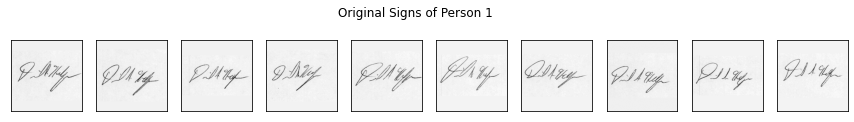

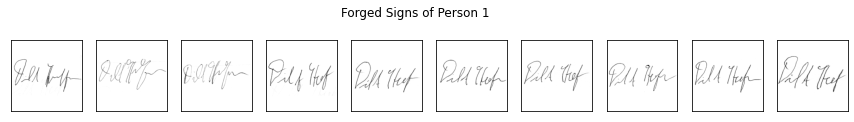

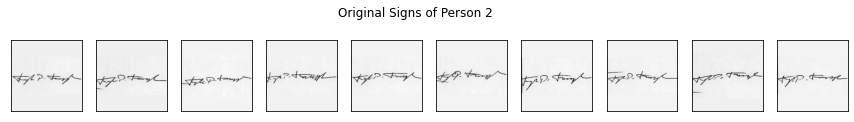

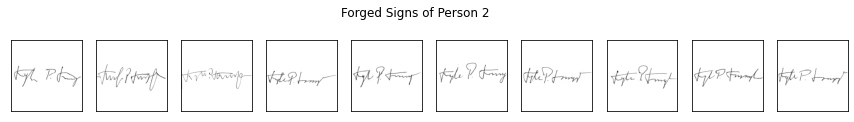

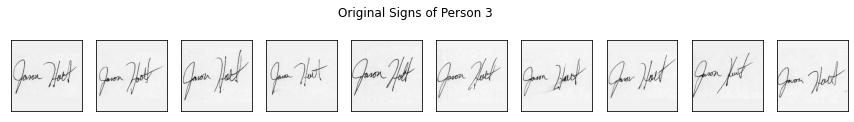

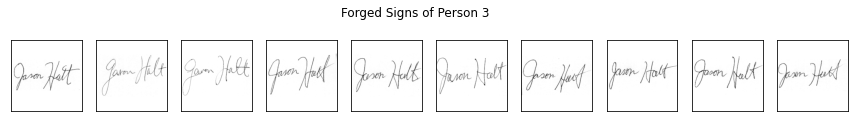

In [89]:
show_samples(orig_images,forge_images,3)

In [0]:
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     rescale=1/255.,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     shear_range=0.05,
#     zoom_range=0.05,
#     brightness_range=[0.8, 1.2],
#     horizontal_flip=False,
#     fill_mode='nearest'
# )

# origSample = datagen.flow(orig_images[:6,:10,:,:].reshape(60,224,224,1),None,batch_size=60,shuffle=False).next().reshape(6,10,224,224)
# forgeSample = datagen.flow(forge_images[:6,:10,:,:].reshape(60,224,224,1),None,batch_size=60,shuffle=False).next().reshape(6,10,224,224)
# print(origSample.shape, forgeSample.shape)
# show_samples(origSample,forgeSample,3)

In [0]:
# def compareWithGeneratedImages(orig,gener,n=10):
#   print(orig.shape,gener.shape)
#   print(orig.min(),orig.max())
#   print(gener.min(),gener.max())
#   for i in range(min(len(orig),n)):
#     plt.figure(figsize=(5,5))
#     plt.subplot(1,2,1)
#     plt.imshow(orig[i].reshape(224,224),cmap='gray')
#     plt.subplot(1,2,2)
#     plt.imshow(gener[i].reshape(224,224),cmap='gray')
# origSample = datagen.flow(orig_images[:6,:2,:,:].reshape(12,224,224,1),None,batch_size=60,shuffle=False).next()
# compareWithGeneratedImages(orig_images[:6,:2,:,:].reshape(12,224,224,1),origSample,12)

In [0]:
train_part = 45
def get_batch(batch_size,dset='train'):
    if dset == 'train':
        origX = orig_images[:train_part]
        forgeX = forge_images[:train_part]
    else:
        origX = orig_images[train_part:]
        forgeX = forge_images[train_part:]
    n_classes, n_examples, w, h = origX.shape
    cat = rng.choice(n_classes, size=batch_size)
    targets = np.zeros((batch_size,1))
    targets[batch_size//2:] = 1
    pairs = [np.zeros((batch_size,w,h,1)) for _ in range(2)]
    for i in range(batch_size):
        ex_no = rng.randint(n_examples)
        ex_no2 = rng.randint(n_examples)
        pairs[0][i,:,:,:] = origX[cat[i],ex_no,:,:].reshape(w,h,1)
        cat2 = 0
        if i >= batch_size // 2:
            pairs[1][i,:,:,:] = origX[cat[i],ex_no2,:,:].reshape(w,h,1)
        else:
            pairs[1][i,:,:,:] = forgeX[cat[i],ex_no2,:,:].reshape(w,h,1)
    # pairs[0] = datagen.flow(pairs[0],None,batch_size=batch_size,shuffle=False).next()
    # pairs[1] = datagen.flow(pairs[1],None,batch_size=batch_size,shuffle=False).next()
    return pairs,targets

In [0]:
# def make_one_shot_task(N,dset='val'):
#     if dset == 'train':
#         origX = orig_images[:train_part]
#         forgeX =forge_images[:train_part]
#     else:
#         origX = orig_images[train_part:]
#         forgeX =forge_images[train_part:]
#     n_classes, n_examples, w, h = origX.shape
#     cat = rng.randint(n_classes)
#     indices1 = rng.choice(n_examples,size=(N//2,),replace=False)
#     indices2 = rng.choice(n_examples,size=(N,),replace=False)
#     ex1 = rng.randint(n_examples)
#     test_image = np.array([origX[cat,ex1]]*N).reshape(N,w,h,1)
#     support_set = forgeX[cat,indices2].reshape(N,w,h,1)
#     support_set[:N//2,:,:,:] = origX[cat,indices1].reshape(N//2,w,h,1)
#     targets = np.zeros((N,1))
#     targets[:N//2] = 1
#     # test_image = datagen.flow(test_image,None,batch_size=N,shuffle=False).next()
#     # support_set = datagen.flow(support_set,None,batch_size=N,shuffle=False).next()
#     test_image,support_set,targets = shuffle(test_image,support_set,targets)
    
#     return [test_image,support_set], targets

In [0]:
# def test_one_shot(model,N,k,dset='val'):
#     n_correct = 0
#     # maxVals = 0
#     for _ in range(k):
#         inputs, outputs = make_one_shot_task(N,dset)
#         preds = model.predict(inputs)
#         # maxVals = max(maxVals,preds.max())
#         # preds=outputs
#         # print(np.round(preds).astype(int))
#         # print(outputs)
#         n_correct += np.sum(outputs == np.round(preds).astype(int))
#     # print('max:',maxVals)
#     return n_correct / (k*N)

In [0]:
def test_one_shot(model,N,k=None,dset='val'):
    if dset == 'train':
        origX = orig_images[:train_part]
        forgeX = forge_images[:train_part]
    else:
        origX = orig_images[train_part:]
        forgeX = forge_images[train_part:]
    n_classes, n_examples, w, h = origX.shape
    cats = shuffle(np.arange(N))
    test_image = []
    support_set = []
    targets = []
    for cat in cats:
      indices1 = rng.choice(n_examples,size=(10,))
      indices2 = rng.choice(n_examples,size=(5,))
      indices3 = rng.choice(n_examples,size=(5,))
      test_image.append(origX[cat,indices1].reshape(-1, w, h, 1))
      support_set.append(origX[cat,indices2].reshape(-1, w, h, 1))
      support_set.append(forgeX[cat,indices3].reshape(-1, w, h, 1))
      targets.append(np.ones(5))
      targets.append(np.zeros(5))
    test_image = np.vstack(test_image)
    support_set = np.vstack(support_set)
    targets = np.array(targets).reshape(-1,1)

    test_image,support_set,targets = shuffle(test_image,support_set,targets)

    preds = model.predict([test_image,support_set])
    return np.sum(targets == np.round(preds).astype(int)) / len(preds)

In [0]:
# test_one_shot(model,10,10)

## Siamese Networks

In [0]:
def get_siamese(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = Sequential()
    
    model.add(Conv2D(32,(5,5),input_shape=input_shape,kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64,(5,5),kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=4,strides=(4,4)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128,(5,5),kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    # # model.add(Dense(512,activation='sigmoid',kernel_regularizer='l2'))
    
    left_emb = model(left_input)
    right_emb = model(right_input)
    
    L1_Layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_Dist = L1_Layer([left_emb,right_emb])
    OP = Dense(1,activation='sigmoid',kernel_regularizer='l2')(L1_Dist)
    
    siamese_net = Model(inputs=[left_input,right_input],outputs=OP)
    
    return siamese_net

In [152]:
num_iterations = 3000
batch_size = 64

evaluateEvery = 100
# Calculate 100 20-way validation testing
k = 55 - train_part
N = 10

n_classes, n_examples, w, h = orig_images[:40].shape

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.05,
    decay_steps=2000,
    decay_rate=0.00001)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model = get_siamese((w, h, 1))

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 15488)        257920      input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 15488)        0           sequential_6[1][0]         

In [153]:
lossArr = []
trainAccArr = []
valAccArr = []
currTime = time.time()
for i in range(0,num_iterations+1):
    x,y = get_batch(batch_size)
    loss = model.train_on_batch(x,y)
    if i % evaluateEvery == 0:
        lossArr.append(loss[0])
        trainAcc = round(test_one_shot(model,N,k,'train') * 100,2)
        valAcc = round(test_one_shot(model,N,k,'val') * 100,2)
        trainAccArr.append(trainAcc)
        valAccArr.append(valAcc)
        print('Iteration',i,'('+str(round(time.time() - currTime,1))+'s) - Loss:',loss[0],'Acc:',round(loss[1],2),'',end='')
        print('Train accuracy:', trainAcc,'%, ',end='')
        print('Val accuracy:', valAcc,'%')
        currTime = time.time()


Iteration 0 (2.6s) - Loss: 2.0540661811828613 Acc: 0.66 Train accuracy: 50.0 %, Val accuracy: 50.0 %
Iteration 100 (45.9s) - Loss: 1.161750316619873 Acc: 0.92 Train accuracy: 50.0 %, Val accuracy: 50.0 %
Iteration 200 (45.8s) - Loss: 0.5620514750480652 Acc: 1.0 Train accuracy: 50.0 %, Val accuracy: 50.0 %
Iteration 300 (45.7s) - Loss: 0.4697023332118988 Acc: 1.0 Train accuracy: 73.0 %, Val accuracy: 70.0 %
Iteration 400 (45.8s) - Loss: 0.11690693348646164 Acc: 1.0 Train accuracy: 50.0 %, Val accuracy: 50.0 %
Iteration 500 (45.7s) - Loss: 0.08037307858467102 Acc: 1.0 Train accuracy: 49.0 %, Val accuracy: 50.0 %
Iteration 600 (45.7s) - Loss: 0.05801734700798988 Acc: 1.0 Train accuracy: 50.0 %, Val accuracy: 50.0 %
Iteration 700 (45.7s) - Loss: 0.04335828125476837 Acc: 1.0 Train accuracy: 50.0 %, Val accuracy: 50.0 %
Iteration 800 (45.4s) - Loss: 0.039529070258140564 Acc: 1.0 Train accuracy: 50.0 %, Val accuracy: 50.0 %
Iteration 900 (45.7s) - Loss: 0.033785417675971985 Acc: 1.0 Train acc

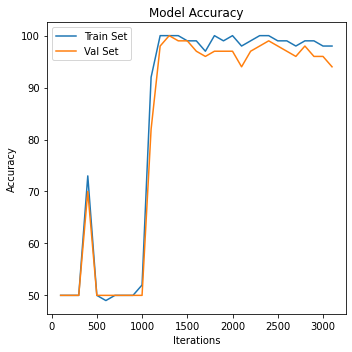

In [154]:
epochs_range = [i*evaluateEvery for i in range(1, len(trainAccArr) + 1)]

plt.figure(figsize=(5,5))

plt.plot(epochs_range, trainAccArr, label='Train Set')
plt.plot(epochs_range, valAccArr, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.tight_layout()
plt.show()

In [157]:
print('Final Validation Accuracy using '+str(k),str(N)+'-way One Shot Learning:', round(test_one_shot(model,N,k,'val') * 100,2))

Final Validation Accuracy using 10 10-way One Shot Learning: 97.0


In [0]:
model.save('signature-siamese-1.h5')

# Test on Unseen Images

In [73]:
test_dir_path = '/content/drive/My Drive/GoogleCollab/data/Signatures/Test Signatures/'
cat_images = []
filenames = []
count = 0
# maxers = [0,0]
for img in tqdm(sorted(os.listdir(test_dir_path))):
  img_path = os.path.join(test_dir_path,img)
  img1 = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2GRAY)
  img1 = cv2.resize(img1,calcResizedShape(img1.shape,224,224))
  top,bottom,left,right = calcPaddingWidths(img1.shape)
  color = np.argmax(cv2.calcHist([img1],[0],None,[256],[0,256]))
  img1 = cv2.copyMakeBorder(img1,top,bottom,left,right,cv2.BORDER_CONSTANT,value=int(color))
  # maxers[0] = max(maxers[0],img1.shape[0])
  # maxers[1] = max(maxers[1],img1.shape[1])
  cat_images.append(img1)
  filenames.append(img)
cat_images = np.array(cat_images)

100%|██████████| 13/13 [00:00<00:00, 188.46it/s]


In [74]:
cat_images.shape

(13, 224, 224)

In [75]:
cv2.imread(test_dir_path+'AmitabhBachchan_01.png').shape

(124, 362, 3)

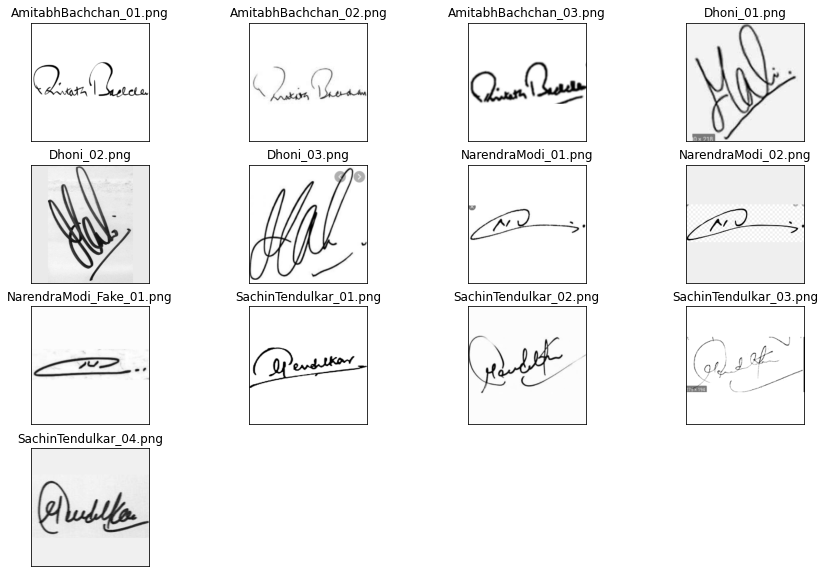

In [76]:
plt.figure(figsize=(15,10))
for i in range(len(filenames)):
  plt.subplot((len(filenames)+3)//4,4,(i+1))
  plt.imshow(cat_images[i],cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title(filenames[i])

In [167]:
sample1, sample2 = 3,4
model.predict([(cat_images[sample1,:,:].reshape(1,224,224,1))/255.,(cat_images[sample2,:,:].reshape(1,224,224,1)/255.)])

array([[0.86406446]], dtype=float32)